# BINARY CLASSIFICATION

##### XGBoost model 
##### annotation result 0, 1 (binary classification)
#####  mean()
##### class weights, medical choice, hyperparameter tuning

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('judge 제거_LCE.csv')

In [27]:
#import missingno as msno
#msno.bar(df)

In [28]:
df = df.dropna(axis=1, thresh=1)

## Preprocessing
#### 1. annotation result = 3, Null drop

In [29]:
# annotation result = 0, 1, 2 만 남기고 확인 

null_annot = list(np.where(df['annotation_result'].isna() == True)[0])
df = df.drop(null_annot, axis = 'index')
df.index = range(len(df))

three_annot = list(np.where(df['annotation_result'] == 3)[0])
df = df.drop(three_annot, axis = 'index')
df.index = range(len(df))

df['annotation_result'].unique()

array([1., 0., 2.])

In [30]:
zero = list(np.where(df['annotation_result'] == 0)[0])
one = list(np.where(df['annotation_result'] == 1)[0])
two = list(np.where(df['annotation_result'] == 2)[0])
df['annotation_result'][zero] = 0
df['annotation_result'][one] = 0
df['annotation_result'][two] = 1

df['annotation_result'].unique()

array([0., 1.])

## 결측치 mean(), train, test split

In [31]:
df = df.fillna(df.mean())

#최빈값
#df = df.fillna(df.mode().iloc[0])
#df

#중앙값
#df = df.fillna(df.median().iloc[0])
#df

In [32]:
# Select all columns except certain columns
X = df.iloc[:,7:]
y = np.ravel(df.loc[:, ['annotation_result']])

from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Training set:  (1427, 70) (1427,)
Test set:  (357, 70) (357,)


## Scaler 적용 

In [33]:
# 1. Standard Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, scale

# Initialize the StandardScaler
#standard_scaler = StandardScaler()
# Fit the scaler on the training data
#standard_scaler.fit(X_train)
# Scale the training, validation, and test data using the scaler
#X_train_standard = standard_scaler.transform(X_train)
#X_val_standard = standard_scaler.transform(X_val)
#X_test_standard = standard_scaler.transform(X_test)


# 2. Initialize the RobustScaler
robust_scaler = RobustScaler()
# Scale the training, validation, and test data using the scaler
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)

# ORIGINAL model

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       271
         1.0       0.73      0.42      0.53        86

    accuracy                           0.82       357
   macro avg       0.79      0.69      0.71       357
weighted avg       0.81      0.82      0.80       357



Text(0.5, 1.0, 'All + Original model')

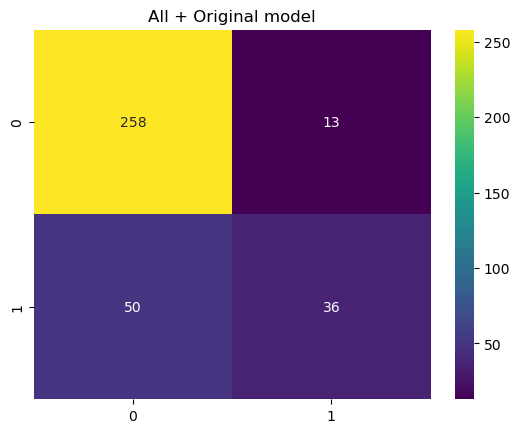

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model_original = XGBClassifier(random_state =42)
model_original.fit(X_train, y_train)

y_pred = model_original.predict(X_test)

# classification report 출력
print(classification_report(y_test, y_pred))

# confusion matrix 출력
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap='viridis')
plt.title("All + Original model")

## Original + Tuning model

Best hyperparameters:  {'subsample': 0.5, 'n_estimators': 160, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.12, 'colsample_bytree': 0.8500000000000003}
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88       271
         1.0       0.70      0.38      0.50        86

    accuracy                           0.81       357
   macro avg       0.77      0.67      0.69       357
weighted avg       0.80      0.81      0.79       357



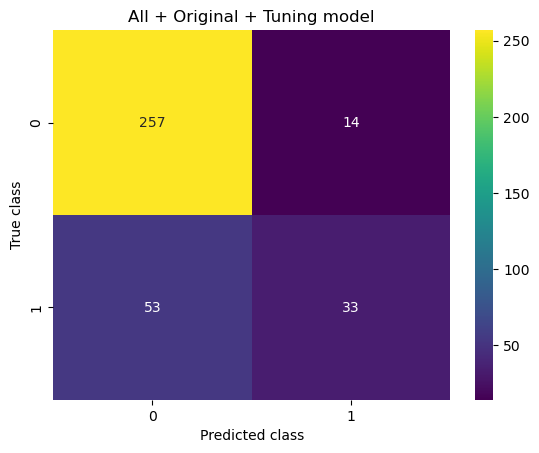

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'max_depth': range(3, 10),
    'n_estimators': range(50, 200, 10),
    'min_child_weight': range(1, 6),
    'subsample': np.arange(0.5, 1, 0.05),
    'colsample_bytree': np.arange(0.5, 1, 0.05)
}

random_search = RandomizedSearchCV(model_original, param_grid, cv = 5)
random_search.fit(X_train, y_train)

print("Best hyperparameters: ", random_search.best_params_)

# 최적의 hypaerparameter로 모델 생성 
best_model = XGBClassifier(**random_search.best_params_, random_state =42)

# 모델 학습
best_model.fit(X_train, y_train)

# 예측 결과 출력
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("All + Original + Tuning model")
plt.show()

## Class weights model

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89       271
         1.0       0.71      0.49      0.58        86

    accuracy                           0.83       357
   macro avg       0.78      0.71      0.74       357
weighted avg       0.82      0.83      0.82       357



Text(0.5, 1.0, 'All + Class weights model')

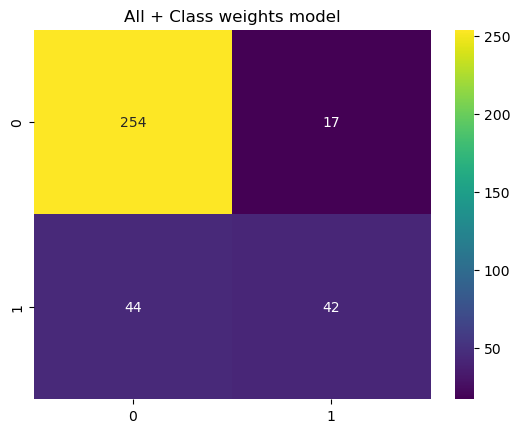

In [36]:
pos_ratio = sum(y_train == 0) / sum(y_train == 1)

# XGBoost 모델 인스턴스화
model_weights = XGBClassifier(
    scale_pos_weight = pos_ratio,
    random_state =42
)

model_weights.fit(X_train, y_train)

y_pred_weights = model_weights.predict(X_test)

print(classification_report(y_test, y_pred_weights))

cm = confusion_matrix(y_test, y_pred_weights)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'viridis')
plt.title("All + Class weights model")

## Class weights + Tuning model

Best hyperparameters:  {'subsample': 0.9500000000000004, 'n_estimators': 160, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.09999999999999999, 'colsample_bytree': 0.7500000000000002}
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       271
         1.0       0.73      0.42      0.53        86

    accuracy                           0.82       357
   macro avg       0.79      0.69      0.71       357
weighted avg       0.81      0.82      0.80       357



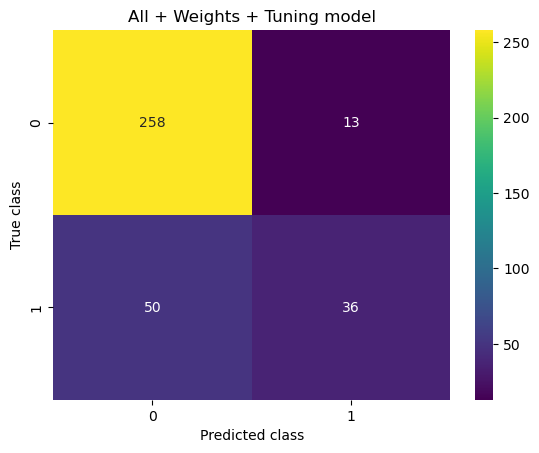

In [37]:
random_search_wt = RandomizedSearchCV(model_weights, param_grid, cv = 5)
random_search_wt.fit(X_train, y_train)

print("Best hyperparameters: ", random_search_wt.best_params_)

# 최적의 hypaerparameter로 모델 생성 
best_model_wt = XGBClassifier(**random_search_wt.best_params_, random_state =42)

# 모델 학습
best_model_wt.fit(X_train, y_train)

# 예측 결과 출력
y_pred_wt = best_model_wt.predict(X_test)
print(classification_report(y_test, y_pred_wt))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred_wt)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("All + Weights + Tuning model")
plt.show()

## Med Selection

In [38]:
# Select all columns except certain columns
X_MED = df.loc[:,['H103','X106','X105','X103','X104','X102','T102','L620','L621','T103','L622','L623',
              'P006','N817','C408','E512','S469','H105','H121','C102','C110','C104','C119',
             'C120','C121','C122','C401','E406','E403','Z977','C153','K087','K086','E427','C404',
             'L464']]
y_MED = np.ravel(df.loc[:, ['annotation_result']])

from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
X_train_MED, X_test_MED, y_train_MED, y_test_MED = train_test_split(X_MED, y_MED, test_size=0.2, random_state=42)

print("Training set: ", X_train_MED.shape, y_train_MED.shape)
print("Test set: ", X_test_MED.shape, y_test_MED.shape)

Training set:  (1427, 36) (1427,)
Test set:  (357, 36) (357,)


## Scaler

In [39]:
# 1. Standard Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, scale

# Initialize the StandardScaler
#standard_scaler = StandardScaler()
# Fit the scaler on the training data
#standard_scaler.fit(X_train)
# Scale the training, validation, and test data using the scaler
#X_train_standard = standard_scaler.transform(X_train)
#X_val_standard = standard_scaler.transform(X_val)
#X_test_standard = standard_scaler.transform(X_test)


# 2. Initialize the RobustScaler
robust_scaler = RobustScaler()
# Scale the training, validation, and test data using the scaler
X_train_MED = robust_scaler.fit_transform(X_train_MED)
X_test_MED = robust_scaler.transform(X_test_MED)

              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89       271
         1.0       0.71      0.40      0.51        86

    accuracy                           0.82       357
   macro avg       0.77      0.67      0.70       357
weighted avg       0.80      0.82      0.79       357



Text(0.5, 1.0, 'MED + Class weights model')

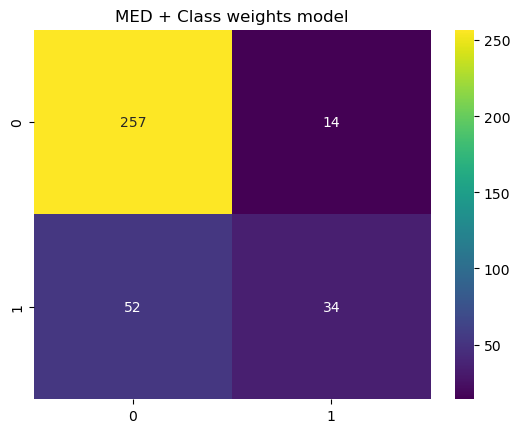

In [40]:
# XGBoost 모델 인스턴스화
model_MED = XGBClassifier(random_state =42)

# 모델 학습 시 class_weight에 class_weights를 전달
model_MED.fit(X_train_MED, y_train_MED)

y_pred_MED = model_MED.predict(X_test_MED)

print(classification_report(y_test_MED, y_pred_MED))

cm = confusion_matrix(y_test_MED, y_pred_MED)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'viridis')
plt.title("MED + Class weights model")

## Med selection + Tuning model

Best hyperparameters:  {'subsample': 0.7000000000000002, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.09, 'colsample_bytree': 0.5}
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       271
         1.0       0.71      0.35      0.47        86

    accuracy                           0.81       357
   macro avg       0.77      0.65      0.68       357
weighted avg       0.80      0.81      0.78       357



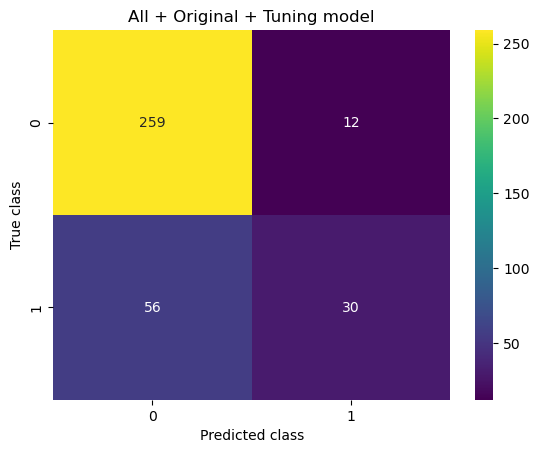

In [41]:
random_search_med = RandomizedSearchCV(model_MED, param_grid, cv = 5)
random_search_med.fit(X_train_MED, y_train_MED)

print("Best hyperparameters: ", random_search_med.best_params_)

# 최적의 hypaerparameter로 모델 생성 
best_model_MED = XGBClassifier(**random_search_med.best_params_, random_state =42)

# 모델 학습
best_model_MED.fit(X_train_MED, y_train_MED)

# 예측 결과 출력
y_pred_MED = best_model_MED.predict(X_test_MED)
print(classification_report(y_test_MED, y_pred_MED))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test_MED, y_pred_MED)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("All + Original + Tuning model")
plt.show()

# Med Selection + Class weights model 

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       271
         1.0       0.71      0.35      0.47        86

    accuracy                           0.81       357
   macro avg       0.77      0.65      0.68       357
weighted avg       0.80      0.81      0.78       357



Text(0.5, 1.0, 'MED + Class weights model')

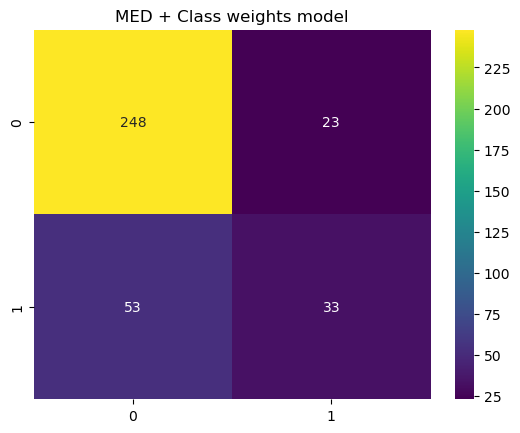

In [42]:
pos_ratio = sum(y_train_MED == 0) / sum(y_train_MED == 1)

# XGBoost 모델 인스턴스화
model_MED_WT = XGBClassifier(
    scale_pos_weight = pos_ratio,
    random_state =42
)

# 모델 학습 시 class_weight에 class_weights를 전달
model_MED_WT.fit(X_train_MED, y_train_MED)

y_pred_MED_WT = model_MED_WT.predict(X_test_MED)

print(classification_report(y_test_MED, y_pred_MED))

cm = confusion_matrix(y_test_MED, y_pred_MED_WT)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'viridis')
plt.title("MED + Class weights model")

# Med selection + Weights + Tuning model

Best hyperparameters:  {'subsample': 0.6500000000000001, 'n_estimators': 170, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.09999999999999999, 'colsample_bytree': 0.7500000000000002}
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       271
         1.0       0.71      0.35      0.47        86

    accuracy                           0.81       357
   macro avg       0.77      0.65      0.68       357
weighted avg       0.80      0.81      0.78       357



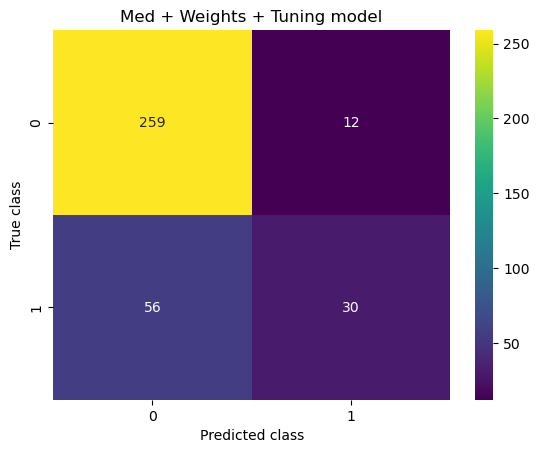

In [43]:
random_search_MED_WT = RandomizedSearchCV(model_MED_WT, param_grid, cv = 5)
random_search_MED_WT.fit(X_train_MED, y_train_MED)

print("Best hyperparameters: ", random_search_MED_WT.best_params_)

# 최적의 hypaerparameter로 모델 생성 
best_model_MED_WT = XGBClassifier(**random_search_MED_WT.best_params_, random_state =42)

# 모델 학습
best_model_MED_WT.fit(X_train_MED, y_train_MED)

# 예측 결과 출력
y_pred_MED_WT = best_model_MED_WT.predict(X_test_MED)
print(classification_report(y_test_MED, y_pred_MED))

# Plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test_MED, y_pred_MED)
sns.heatmap(cm, annot=True, fmt = 'd', cmap="viridis")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Med + Weights + Tuning model")
plt.show()

## AUROC 

Original's AUC:  0.8122800995451815
Original + Tuning's AUC:  0.8035269887582597
Weights's AUC:  0.8238221917102891
Weights + Tuning's AUC:  0.8126662661975458
Med's AUC:  0.8211190251437398
Med + Tuning's AUC:  0.8307302840470265
Med + Weights + Tuning's AUC:  0.8185874882004635
Med + Weights + Tuning's AUC:  0.8339054320775766


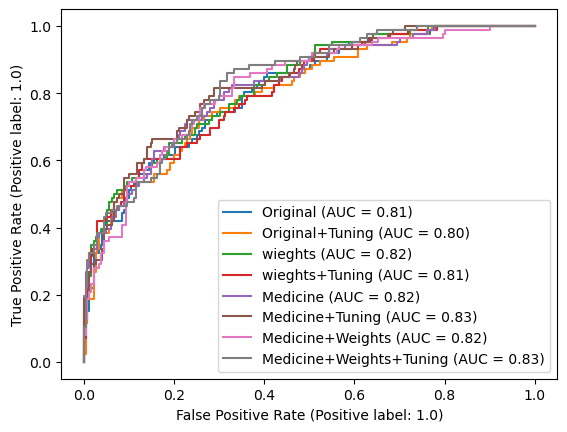

In [44]:
from sklearn.metrics import roc_auc_score, plot_roc_curve, RocCurveDisplay 

fig, ax = plt.subplots()

plot_roc_curve(model_original, X_test, y_test, ax=ax, name = 'Original')
plot_roc_curve(best_model, X_test, y_test, ax=ax, name = 'Original+Tuning')

plot_roc_curve(model_weights, X_test, y_test, ax=ax, name = 'wieghts')
plot_roc_curve(best_model_wt, X_test, y_test, ax=ax, name = 'wieghts+Tuning')

plot_roc_curve(model_MED, X_test_MED, y_test_MED, ax=ax, name = 'Medicine')
plot_roc_curve(best_model_MED, X_test_MED, y_test_MED, ax=ax, name = 'Medicine+Tuning')

plot_roc_curve(model_MED_WT, X_test_MED, y_test_MED, ax=ax, name = 'Medicine+Weights')
plot_roc_curve(best_model_MED_WT, X_test_MED, y_test_MED, ax=ax, name = 'Medicine+Weights+Tuning')


y_pred_proba1 = model_original.predict_proba(X_test)[:, 1]
auc1 = roc_auc_score(y_test, y_pred_proba1)
print("Original's AUC: ", auc1)

y_pred_proba2 = best_model.predict_proba(X_test)[:, 1]
auc2 = roc_auc_score(y_test, y_pred_proba2)
print("Original + Tuning's AUC: ", auc2)


y_pred_proba3 = model_weights.predict_proba(X_test)[:, 1]
auc3 = roc_auc_score(y_test, y_pred_proba3)
print("Weights's AUC: ", auc3)

y_pred_proba4 = best_model_wt.predict_proba(X_test)[:, 1]
auc4 = roc_auc_score(y_test, y_pred_proba4)
print("Weights + Tuning's AUC: ", auc4)


y_pred_proba5 = model_MED.predict_proba(X_test_MED)[:, 1]
auc5 = roc_auc_score(y_test_MED, y_pred_proba5)
print("Med's AUC: ", auc5)

y_pred_proba6 = best_model_MED.predict_proba(X_test_MED)[:, 1]
auc6 = roc_auc_score(y_test_MED, y_pred_proba6)
print("Med + Tuning's AUC: ", auc6)


y_pred_proba7 = model_MED_WT.predict_proba(X_test_MED)[:, 1]
auc7 = roc_auc_score(y_test_MED, y_pred_proba7)
print("Med + Weights + Tuning's AUC: ", auc7)

y_pred_proba8 = best_model_MED_WT.predict_proba(X_test_MED)[:, 1]
auc8 = roc_auc_score(y_test_MED, y_pred_proba8)
print("Med + Weights + Tuning's AUC: ", auc8)

plt.show()